## Sandbox for getting article pair similarity after filtering by named entities 

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [3]:
#NOTE: very important, which entity categories to keep 
#article showing all entity types below
# https://www.kaggle.com/code/curiousprogrammer/entity-extraction-and-classification-using-spacy
TO_KEEP = ["org","event", "person", "work_of_art", "product"]
CLUSTER_CUTOFF = [5, 1000]
#for testing 
NROWS = 20000
OUT_PATH = "/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/entityPairs2020test.pkl"

In [4]:
#load in main data source 
#we don't want to use "content", because it takes up a lot of space and
#we have already embedded the content. Can always merge back in later so long as we 
#keep the "key" column
LOAD_COLS = list(pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNER.tsv", \
                     nrows = 1, sep="\t").columns)
LOAD_COLS.remove("content")

## this might take a minute 

In [5]:
#load in main data source 
print("loading news data")
df = pd.read_csv("/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNER.tsv",\
                 nrows=NROWS, sep="\t", usecols = LOAD_COLS)

df["date"] = pd.to_datetime(df["date"])

df["year"] = df["date"].dt.year

#filter so we only use 2020 where we have Reuters 
df = df[df["year"] == 2020]

#get length of new rows 
print(str(len(df)) + " rows in 2020 df")

#load in Embeddings, which haven't been merged yet
#we merge them in this step because they are very large and don't
#want to write them to disk again if we can help it
print("loading embeddings")
embeddingsDf = pd.read_csv("/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/embeddingsKeys.tsv", sep="\t", nrows=NROWS, names=["key", "embedding"], converters={"embedding":lambda x: np.array(x.strip("[]").split(","), dtype=float)})

print("merging embeddings")
df = pd.merge(df, embeddingsDf, how="inner", on="key")
df.dropna(subset=["key", "embedding"])
print(str(len(df)) + " rows after merging, dropping na keys, embeddings")

loading news data
20000 rows in 2020 df
loading embeddings
merging embeddings
20000 rows after merging, dropping na keys, embeddings


In [6]:
print("date range: ")
print(max(pd.to_datetime(df["date"])))
print(min(pd.to_datetime(df["date"])))

date range: 
2020-04-11 00:00:00
2020-04-01 00:00:00


In [7]:
leanDf = df[["key", "NamedEntities", "embedding"]]

print("parsing")

def cleanList(inList): 
    return [str(re.sub("[^a-zA-Z0-9 ]", "", item).lower()) for item in inList]

def parseList(inStr): 
    split = inStr.split("\'), (\'")
    return [cleanList(item.split("', '")) for item in split]

#parse topics from string to actual list of tuples 
leanDf["NamedEntities"] = leanDf["NamedEntities"].apply(parseList)

print("parsed")

#test out idea for creating reverse mapping 
#how many na vals do we have in "NamedEntities"? 
print(str(sum(leanDf["NamedEntities"].isna())) + " NA values in Named Entities column")
print("Filling with '' instead")
leanDf["NamedEntities"] = leanDf["NamedEntities"].fillna("")


parsing
parsed
0 NA values in Named Entities column
Filling with '' instead


<ipython-input-7-96b6a3b18fd8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leanDf["NamedEntities"] = leanDf["NamedEntities"].apply(parseList)
<ipython-input-7-96b6a3b18fd8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leanDf["NamedEntities"] = leanDf["NamedEntities"].fillna("")


Note: we see below that we have things like "date: week" as named entities. This must be addressed somewhere 

In [8]:
#bring each tuple into its own row 
print("exploding #1")
leanDf = leanDf.explode("NamedEntities")

#bring each tuple entry into its own column 
#split ent_type, entity pairs to columns 
print("splitting entity, type")
leanDf[["ent_type","entity"]] = pd.DataFrame(leanDf["NamedEntities"].tolist(), index=leanDf.index)

#remove occurences where we double count an entity for the same article 
leanDf = leanDf.drop_duplicates(subset=["key", "ent_type", "entity"])

print("filtering by entity type, grouping")
#keep only the entity types that may be interesting 
leanDf = leanDf[leanDf["ent_type"].isin(TO_KEEP)]

#group articles by their named entities  
groupedDf = leanDf[["ent_type", "entity", "key", "embedding"]].groupby(by=["ent_type", "entity"]).agg(list)

print(str(len(groupedDf)) + " rows in entity-grouped df")

exploding #1
splitting entity, type
filtering by entity type, grouping
104949 rows in entity-grouped df


In [9]:
groupedDf["numArticles"] = groupedDf["key"].apply(len)

print("filtering clusters not between 5, 1000")
#only keep named entity clusters that are of a particular size 
groupedDf = groupedDf[(groupedDf["numArticles"] >= CLUSTER_CUTOFF[0]) & (groupedDf["numArticles"] <= CLUSTER_CUTOFF[1])]

print("down to " + str(groupedDf.shape[0]) + " clusters ") 

filtering clusters not between 5, 1000
down to 8094 clusters 


Text(0.5, 0.98, 'Named Entity Cluster Size Distribution')

<Figure size 432x288 with 0 Axes>

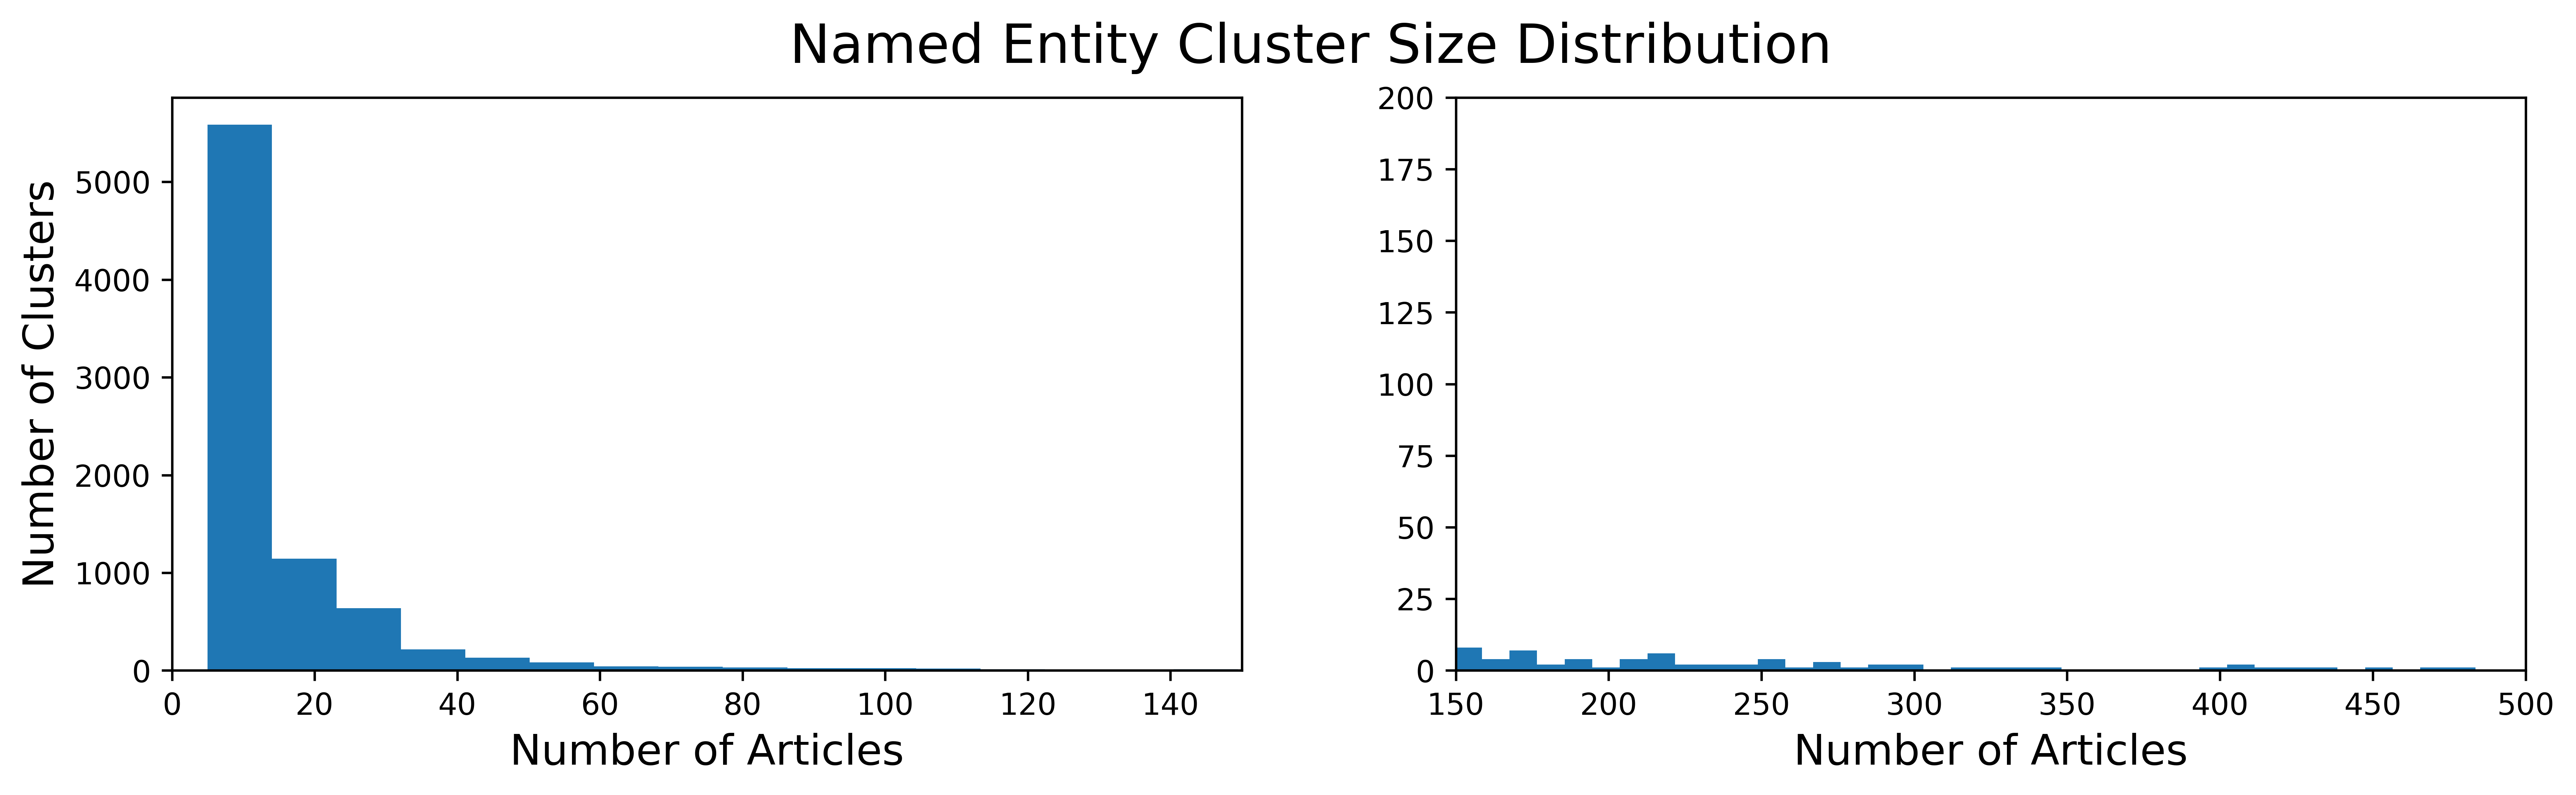

In [10]:
plt.clf()
plt.rcParams['figure.dpi'] = 600
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[14, 3.5])

axs[0].hist(groupedDf["numArticles"], bins=100)
axs[0].set_xlim([0, 150])
axs[0].set_xlabel("Number of Articles", size=14)
axs[0].set_ylabel("Number of Clusters", size=14)

axs[1].hist(groupedDf["numArticles"], bins=100)
axs[1].set_xlim([150, 500])
axs[1].set_ylim([0, 200])
axs[1].set_xlabel("Number of Articles", size=14)
fig.suptitle("Named Entity Cluster Size Distribution", size=18)


In [11]:
#now that we have clusters, we want to get embeddings 
#first, we need to unravel the clusters so that we have pairwise rows

In [12]:
#define functions for getting pairs from a list 
def getPairwise(inList): 
    outList = []
    inLen = len(inList)
    for i in range(0, inLen):
        for j in range(i+1, inLen): 
            outList.append([inList[i], inList[j]])
    return outList
    
def getPairwiseSim(inList):
    outList = []
    inLen = len(inList)
    for i in range(0, inLen):
        for j in range(i+1, inLen):
            sim = 1-distance.cosine(inList[i], inList[j])
            outList.append(sim)
            
    return outList

# NOTE: this step uses lots of memory 
# 1% when using 300,000 rows of original data 

In [13]:
#def getPairwise(inList): 
#    return [(item1, item2) for item2 in inList for item1 in inList]

print("HIGH MEMORY: getting pairs")
#we only needed the articleNum column for filtering 
groupedDf = groupedDf[["key", "embedding"]]

#get all of the pairs for a given list of articles and a given list of embeddings 
groupedDf["embedding"] = groupedDf["embedding"].apply(getPairwise)
groupedDf["key"] = groupedDf["key"].apply(getPairwise)

HIGH MEMORY: getting pairs


In [14]:
import gc
del leanDf 
del df 
gc.collect()

22

In [15]:
#give each 
print("HIGH MEMORY: exploding pairs")
pairDf = groupedDf.apply(pd.Series.explode)
pairDf.shape

HIGH MEMORY: exploding pairs


(6768967, 2)

In [16]:
del groupedDf
gc.collect()

44

In [17]:
print("making key columns")
pairDf[["key1", "key2"]] = pd.DataFrame(pairDf["key"].to_list(), index=pairDf.index)
pairDf = pairDf.drop(columns=["key"]).reset_index()

making key columns


### NOTE: 
this may be a line to consider if we are interested in knowing how many clusters a pair is in 

In [18]:
#pairDf.groupby(by=["key1", "key2"]).agg({"ent_type":list, "entity":list, "embedding":lambda x: x.iloc[0]})

### NOTE: 
this is for memory preservation, we need to also drop duplicates that are simply the reverse direction of eachother. This may happen automatically when we create an undirected graph from these 

Maybe try a duplicate removal solution from here: https://stackoverflow.com/questions/44792969/pandas-drop-duplicates-based-on-subset-where-order-doesnt-matter

In [19]:
print("dropping duplicates")
pairDf = pairDf.drop_duplicates(subset=["key1", "key2"])
print("final length of " + str(len(pairDf)) + " rows")

dropping duplicates
final length of 4780642 rows


In [20]:
pairDf = pairDf.reset_index(drop=True)

In [21]:
pairDf.to_pickle(OUT_PATH)

### NOTE: 
This cell (below) will be put in another file. want to simply write out pairwise dataframe and then reload to avoid any memory overhead we may have. 